In [3]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pandas as pd
import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import preprocessing
from keras.utils import np_utils
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv("../data/titanic/train.csv")
test = pd.read_csv("../data/titanic/test.csv")
train = train.append(test) ## test 데이터도 학습에 이용.

# inplace=True 로 해야 모든 컬럼에 대해 fillna 가 이뤄짐.
# train.fillna(0, inplace=True) 
# test.fillna(0, inplace=True)


print(train.shape)
print(test.shape)

train



(1309, 12)
(418, 11)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [4]:

# cols = PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked

# 데이터 전처리 : 학습에 필요없는 column 제거.
train.pop('Name'), test.pop('Name')
train.pop('Ticket'), test.pop('Ticket')
train.pop('Cabin'), test.pop('Cabin')
train.pop('PassengerId'), test.pop('PassengerId') # 제거하지 않으면 passengerId 가 높을수록 predicton value 가 높은 현상

# train 은 Nan data 제거하고, test 는 row 수를 유지하기 위해 drop 대신 fill.
train.dropna(inplace=True)
test.fillna(0, inplace=True)
print(train.shape)
print(test.shape)

# 데이터 전처리 : One Hot Encoding
# 성별, 승선지 는 String data. -> labelBinarizer를 이용해서 자동으로 one-hot-encoding
# 컬럼의 data 종류 학습.
# one-hot-encode 형태의 컬럼 추가.
# 구 컬럼 삭제 ( DataFrame.pop() )
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
enc = encoder.fit(train[['Embarked']].astype(str))
train = pd.merge(train, pd.DataFrame(enc.transform(train[['Embarked']].astype(str))) , right_index=True, left_index=True)
test = pd.merge(test, pd.DataFrame(enc.transform(test[['Embarked']].astype(str))) , right_index=True, left_index=True)
enc = encoder.fit(train[['Sex']].astype(str))
train = pd.merge(train, pd.DataFrame(enc.transform(train[['Sex']].astype(str))) , right_index=True, left_index=True)
test = pd.merge(test, pd.DataFrame(enc.transform(test[['Sex']].astype(str))) , right_index=True, left_index=True)
train.pop('Embarked'), test.pop('Embarked')
train.pop('Sex'), test.pop('Sex')

# label
y_train = train[['Survived']]

# feature
train.pop('Survived')
x_train = train
x_test = test

x_train.head(5)



(712, 8)
(418, 7)


,Age,Fare,Parch,Pclass,SibSp,0_x,1,2,0_y
0,22.0,7.2500,0,3,1,0,0,1,1
1,38.0,71.2833,0,1,1,1,0,0,0
2,26.0,7.9250,0,3,0,0,0,1,0
3,35.0,53.1000,0,1,1,0,0,1,0
4,35.0,8.0500,0,3,0,0,0,1,1


In [5]:
# #### outlier detection #####
# from sklearn.cluster import DBSCAN
# outlier_detection = DBSCAN(
#     eps = 50,
#     metric="euclidean",
#     n_jobs = -1)
# clusters = outlier_detection.fit_predict(train[['Fare']])
# clusters

In [6]:
# mixmax scaler, normalizer 등의 전처리 아직 없음.

(array([ 264.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  182.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

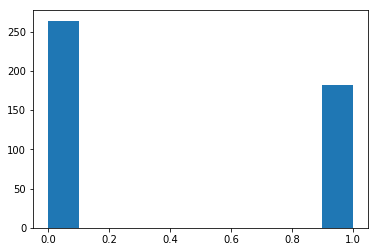

In [7]:
# 대강의 label 분포 보기
plt.hist(y_train['Survived'])

In [8]:
x_test.head(5)

,Pclass,Age,SibSp,Parch,Fare,0_x,1,2,0_y
0,3,34.5,0,0,7.8292,0,1,0,1
1,3,47.0,1,0,7.0000,0,0,1,0
2,2,62.0,0,0,9.6875,0,1,0,1
3,3,27.0,0,0,8.6625,0,0,1,1
4,3,22.0,1,1,12.2875,0,0,1,0


In [15]:

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=len(x_train.columns)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5)) # 과적합방지 Dropout. 
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# opt = optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
opt = optimizers.Adam(lr=0.0001, decay=0.1, amsgrad=True)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print(model.summary)

hist = model.fit(x_train, y_train, epochs=500, batch_size=50,validation_split=0.1)

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x1a2b58e1d0>>
Train on 401 samples, validate on 45 samples
Epoch 1/500
401/401 [==============================] - 1s 2ms/step - loss: 0.7134 - acc: 0.5287 - val_loss: 0.6940 - val_acc: 0.4667
Epoch 2/500
401/401 [==============================] - 0s 160us/step - loss: 0.6924 - acc: 0.5935 - val_loss: 0.6946 - val_acc: 0.4667
Epoch 3/500
401/401 [==============================] - 0s 163us/step - loss: 0.6893 - acc: 0.6010 - val_loss: 0.6948 - val_acc: 0.4667
Epoch 4/500
401/401 [==============================] - 0s 132us/step - loss: 0.6895 - acc: 0.5960 - val_loss: 0.6949 - val_acc: 0.4667
Epoch 5/500
401/401 [==============================] - 0s 123us/step - loss: 0.6884 - acc: 0.6060 - val_loss: 0.6954 - val_acc: 0.4667
Epoch 6/500
401/401 [==============================] - 0s 118us/step - loss: 0.6873 - acc: 0.6060 - val_loss: 0.6956 - val_acc: 0.4667
Epoch 7/500
401/401 [==============================] 

401/401 [==============================] - 0s 126us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7244 - val_acc: 0.4667
Epoch 61/500
401/401 [==============================] - 0s 124us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7238 - val_acc: 0.4667
Epoch 62/500
401/401 [==============================] - 0s 119us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7246 - val_acc: 0.4667
Epoch 63/500
401/401 [==============================] - 0s 121us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7254 - val_acc: 0.4667
Epoch 64/500
401/401 [==============================] - 0s 121us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7262 - val_acc: 0.4667
Epoch 65/500
401/401 [==============================] - 0s 124us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7271 - val_acc: 0.4667
Epoch 66/500
401/401 [==============================] - 0s 135us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7279 - val_acc: 0.4667
Epoch 67/500
401/401 [==============================] - 0s 14

401/401 [==============================] - 0s 142us/step - loss: 0.6705 - acc: 0.6060 - val_loss: 0.7319 - val_acc: 0.4667
Epoch 121/500
401/401 [==============================] - 0s 139us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7311 - val_acc: 0.4667
Epoch 122/500
401/401 [==============================] - 0s 119us/step - loss: 0.6705 - acc: 0.6060 - val_loss: 0.7318 - val_acc: 0.4667
Epoch 123/500
401/401 [==============================] - 0s 138us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7309 - val_acc: 0.4667
Epoch 124/500
401/401 [==============================] - 0s 133us/step - loss: 0.6705 - acc: 0.6060 - val_loss: 0.7315 - val_acc: 0.4667
Epoch 125/500
401/401 [==============================] - 0s 138us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7322 - val_acc: 0.4667
Epoch 126/500
401/401 [==============================] - 0s 139us/step - loss: 0.6705 - acc: 0.6060 - val_loss: 0.7313 - val_acc: 0.4667
Epoch 127/500
401/401 [==============================] 

401/401 [==============================] - 0s 124us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7349 - val_acc: 0.4667
Epoch 180/500
401/401 [==============================] - 0s 119us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7355 - val_acc: 0.4667
Epoch 181/500
401/401 [==============================] - 0s 147us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7361 - val_acc: 0.4667
Epoch 182/500
401/401 [==============================] - 0s 129us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7350 - val_acc: 0.4667
Epoch 183/500
401/401 [==============================] - 0s 120us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7355 - val_acc: 0.4667
Epoch 184/500
401/401 [==============================] - 0s 120us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7345 - val_acc: 0.4667
Epoch 185/500
401/401 [==============================] - 0s 110us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7336 - val_acc: 0.4667
Epoch 186/500
401/401 [==============================] 

Epoch 239/500
401/401 [==============================] - 0s 128us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7370 - val_acc: 0.4667
Epoch 240/500
401/401 [==============================] - 0s 145us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7377 - val_acc: 0.4667
Epoch 241/500
401/401 [==============================] - 0s 139us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7365 - val_acc: 0.4667
Epoch 242/500
401/401 [==============================] - 0s 118us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7370 - val_acc: 0.4667
Epoch 243/500
401/401 [==============================] - 0s 119us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7359 - val_acc: 0.4667
Epoch 244/500
401/401 [==============================] - 0s 112us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7350 - val_acc: 0.4667
Epoch 245/500
401/401 [==============================] - 0s 121us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7356 - val_acc: 0.4667
Epoch 246/500
401/401 [==================

Epoch 299/500
401/401 [==============================] - 0s 123us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7359 - val_acc: 0.4667
Epoch 300/500
401/401 [==============================] - 0s 117us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7364 - val_acc: 0.4667
Epoch 301/500
401/401 [==============================] - 0s 115us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7370 - val_acc: 0.4667
Epoch 302/500
401/401 [==============================] - 0s 118us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7376 - val_acc: 0.4667
Epoch 303/500
401/401 [==============================] - 0s 122us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7381 - val_acc: 0.4667
Epoch 304/500
401/401 [==============================] - 0s 125us/step - loss: 0.6709 - acc: 0.6060 - val_loss: 0.7370 - val_acc: 0.4667
Epoch 305/500
401/401 [==============================] - 0s 126us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7375 - val_acc: 0.4667
Epoch 306/500
401/401 [==================

Epoch 359/500
401/401 [==============================] - 0s 128us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7335 - val_acc: 0.4667
Epoch 360/500
401/401 [==============================] - 0s 131us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7326 - val_acc: 0.4667
Epoch 361/500
401/401 [==============================] - 0s 128us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7317 - val_acc: 0.4667
Epoch 362/500
401/401 [==============================] - 0s 121us/step - loss: 0.6705 - acc: 0.6060 - val_loss: 0.7323 - val_acc: 0.4667
Epoch 363/500
401/401 [==============================] - 0s 121us/step - loss: 0.6705 - acc: 0.6060 - val_loss: 0.7330 - val_acc: 0.4667
Epoch 364/500
401/401 [==============================] - 0s 132us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7336 - val_acc: 0.4667
Epoch 365/500
401/401 [==============================] - 0s 122us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7326 - val_acc: 0.4667
Epoch 366/500
401/401 [==================

Epoch 419/500
401/401 [==============================] - 0s 133us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7345 - val_acc: 0.4667
Epoch 420/500
401/401 [==============================] - 0s 122us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7335 - val_acc: 0.4667
Epoch 421/500
401/401 [==============================] - 0s 120us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7342 - val_acc: 0.4667
Epoch 422/500
401/401 [==============================] - 0s 126us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7348 - val_acc: 0.4667
Epoch 423/500
401/401 [==============================] - 0s 148us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7354 - val_acc: 0.4667
Epoch 424/500
401/401 [==============================] - 0s 129us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7344 - val_acc: 0.4667
Epoch 425/500
401/401 [==============================] - 0s 127us/step - loss: 0.6706 - acc: 0.6060 - val_loss: 0.7350 - val_acc: 0.4667
Epoch 426/500
401/401 [==================

Epoch 479/500
401/401 [==============================] - 0s 114us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7364 - val_acc: 0.4667
Epoch 480/500
401/401 [==============================] - 0s 115us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7371 - val_acc: 0.4667
Epoch 481/500
401/401 [==============================] - 0s 119us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7359 - val_acc: 0.4667
Epoch 482/500
401/401 [==============================] - 0s 126us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7364 - val_acc: 0.4667
Epoch 483/500
401/401 [==============================] - 0s 147us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7370 - val_acc: 0.4667
Epoch 484/500
401/401 [==============================] - 0s 151us/step - loss: 0.6708 - acc: 0.6060 - val_loss: 0.7360 - val_acc: 0.4667
Epoch 485/500
401/401 [==============================] - 0s 140us/step - loss: 0.6707 - acc: 0.6060 - val_loss: 0.7350 - val_acc: 0.4667
Epoch 486/500
401/401 [==================

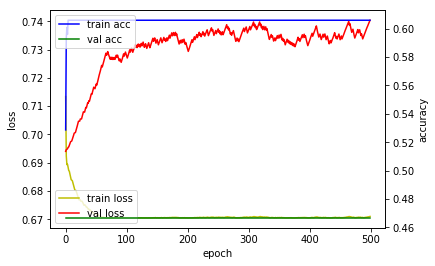

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [20]:
model.predict(x_test)

array([[ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.3782391 ],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.40945926],
       [ 0.37813804],
       [ 0.62574017],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37822151],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.42307591],
       [ 0.37813804],
       [ 0.4017171 ],
       [ 0.37813804],
       [ 0.37813804],
       [ 0.37813804],
       [ 0

(array([ 402.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   16.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

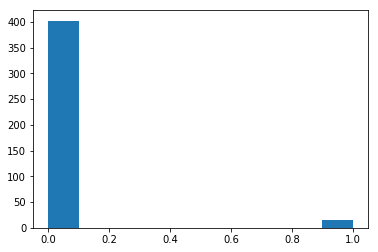

In [21]:
pred = model.predict_classes(x_test)
# live = len([x for x in pred.ravel() if x==1])
# death = len([x for x in pred.ravel() if x==0])
# print("live : " , live)
# print("death : " , death)
# print("생존율 : ", live / (live + death))
# pred

plt.hist(pred)

In [22]:
df_pred = pd.read_csv("../data/titanic/gender_submission.csv")
df_pred[['Survived']] = pred
# df_pred

In [23]:
df_pred.to_csv('result.csv', index=False)